## NASA Frontier Development Lab - Disaster Prevention, Progress and Response (Floods)

Floods are the most destructive and dangerous natural disasters worldwide. All regions can be affected by flooding events and, with the increased variability in weather patterns due to global warming, this is likely to become even more prelevant. The speed at which flooding events can occur, and difficulties in predicting their occurrance, create huge logistic problems for both governmental and non-governmental agencies. Over the past 10 years, floods have caused on average 95 deaths a year in the US alone, making them the deadliest weather related phenomenon. Worldwide, floods cost in excess of 40 Billion dollars per year, impacting property, agriculture and the health of individuals.

Throughout the duration of the project, we collaborated with United States Geological Survey (USGS), a scientific agency within the US Department of the Interior. The objective of this organization is to study the landscape of the US and provide information about its natural resources and the natural hazards that affect them. Currently, hydrologists use physical models to help predict floods. These models require predictions to be carefully calibrated for each stream or watershed and careful consideration must be taken for dams, levees etc. Producing these models is extremely costly due to resource requirements. This limits the areas within the US that can avail of such systems to better prepare for flood events.

To predict the flood susceptibility of a stream area, the project was separated into two distinct problems.

**Monthly Model**

Predicting, per month, if a stream height will reach a predefined flood threshold. These flood thresholds are set by the National Oceanic and Atmospheric Administration (NOAA) and were location specific. Knowing which areas are susceptible to flooding, allow locations to better prepare for a flood event.

**Time to Peak Model**

Predicting the time taken for a stream/river to reach it's peak height. Following a major rain event occurs, knowing how long it will take for a river to reach this height is vital in order to inform potentially affected individuals if and when they need to evacuate. This can help to reduce structural damage and loss of life during a disaster.

## The Data

This project focused on 6 states within the US, over a period of 10 years. Data was taken from ~800 gauge sites, between July 2009 and June 2019. Not all gauge sites had continuous historical data over the period, but all the available data for each site was used.

The 6 states were:

    -New Jersey
    -Nebraska
    -South Carolina
    -New York
    -South Dakota
    -Virginia
    
A primary reason for choosing these states, was that each exhibits similar climate and landscape. Focusing on similar geographies from a machine learning perspective ensures that the models produced could be generalized to similar regions and given assumed reduced variability in conditions, models that are more precise.

Other required datasets and providers:

**USGS**

This consists of the height of a stream as measured by gauges for over 11,000 sites in the US. The data is updated every 15 minutes, with some locations having historical data for over 50 years. 

**PRISM**

The PRISM Climate Group provides climate observations across the whole of the US. This dataset was used to extract daily precipitation readings from the site locations for each day during the requested 10 year period.

**National Land Cover Database (NLCD)**

The NLCD database was collected using Landsat. This provides information such as land-use classification (urban, agriculture, forest, etc.), how well the land allows water to pass through it (impervious surface information) and tree cover. This dataset has updated records every 5 years from 2006.

**National Hydrology Dataset Plus (NHDPlus)**

NHDPlus is a geo-spatial hydrologic framework dataset associated with USGS. The features used from this dataset were the catchment and drainage area characteristics at the stream site locations. 

**Flooded Locations And Simulated Hydrographs Project (FLASH)**

FLASH is a database containing information about flood events within the US. The information used from this dataset was the time taken for a river to reach its peak height after a major rain event.

**NOAA**

NOAA is a US governmental agency for monitoring and preserving the climate and environment. The data provided by NOAA surrounded flood level thresholds for locations across the US. These thresholds consisted of four warning stages and the river height for a given location that causes them to reach these levels. The four warning stages were:

|Warning |  Meaning                                                                                     |
|--------|-------                                                                                     |
|Action  |	Mitigation action needs to be taken in order to prepare for possible hydrological activity|
|Flood	 |  The river height poses a threat to lives, property and businesses|
|Moderate| 	Some inundation of roads or buildings. A flood warning should be released|
|Major	 |  Extensive inundation of roads and buildings. Considerable evacuations of areas may occur|


A more indepth discussion on these datasources can be found within the associated whitepaper.

An implementation describing how to download the stream gauge height data from USGS over the 10 year period can be found in the stream.q file

## Load Required Libraries and Python Functionality

#### Load Relevant Python functionality

In [1]:
// Load embedPy
\l p.q

// Data manipulation
np:.p.import[`numpy]
gp :.p.import[`geopandas]
train_test_split:.p.import[`sklearn.model_selection]`:train_test_split

// Plotting functionality
plt:.p.import[`matplotlib.pyplot]

// Scoring functionality and machine learning models
precision_recall_curve :.p.import[`sklearn.metrics]`:precision_recall_curve
average_precision_score:.p.import[`sklearn.metrics]`:average_precision_score
RandomForestClassifier :.p.import[`sklearn.ensemble]`:RandomForestClassifier
XGBClassifier          :.p.import[`xgboost]`:XGBClassifier

/home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Relevant libraries and scripts

In [2]:
// Load the machine learning toolkit
\l ml/ml.q 
.ml.loadfile`:init.q

// Load flood data and associated code
\l ../floods.q
.fld.loadfile`:init.q

## Data Preprocessing

Due to the variety of data sources and datasets used, preprocessing the data is of critical importance. This step ensures that feature engineering completed later in the pipeline is more seamless. The following are the operations taken on the data at this stage.

1. Prepend any stream-site names containing less than 8 values with 0's to ensure consist lengths
2. Remove rows containing nulls or infinities from the datasets as these can't be passed to machine learning algorithms.
3. Add a column denoting the index of each location in the NOAA threshold dataset (used for nearest neighbours calculations)
4. Modify site id's in the PRISM dataset such that no site id's are the same and a limit of 12 digits for an individual site is adhered to.
5. Add a column to allow the NLCD dataset which is updated every 5 years to be joined later in the notebook

In [3]:
// Utility functions

/ Functional delete
del:{![x;enlist (=;y;z);0b;`symbol$()]}

/ Prepend sites with 7 numbers with a 0
conv7_fn:{`$$[7=count x;"0",;]x}

Steps: 1 -> 3

In [4]:
// Remove nulls from the precipitation dataset
precip:update conv7_fn each string each site_no from del[precipall;`ppt;0n]

// Remove infinities from maximum stream height dataset
maxht:update conv7_fn each site_no from del[max_ht_str;`height;neg[0w]]

// Insert index column for warning dataset
warning:update nn:i from warnings

Step: 4

Manipulation of the PRISM dataset is more involved. The steps taken are as follows with each step associated with an individual code block

1. Find all sites from PRISM data with more than 12 digits
2. Locate sites in the precipitation data associated with the PRISM dataset
3. Removal of trailing site id's can cause clashes, in this data such a clash only occurs at index 20 in the names table. Get the index at which these clashes occur and splits them based on lat/long.
4. Create exception lists and new id lists in order to correctly process data
5. Update the precipitation table based on the updates to id's and clashes

In [5]:
rms:asc ds where 12<count each ds:string exec distinct site_no from gauges 

names:0!select i by site_no from precip where site_no in `$12#'rms

matchnames:0!select i by lat,long from precip where i in names[`x][20]

lst1:til[26]except 21 22; lst2:til[25]except 20
i1:`$rms[lst1],rms[21 22]; i2:(names[`x]lst2),matchnames`x

precip:{![x;enlist(in;`i;z);0b;enlist[`site_no]!enlist enlist y]}/[precip;i1;i2]

Step 5:

In [6]:
// Bin the year information into 2006,2011 and 2016 associated with each used NLCD dataset
nlcdyear:{$[x<2011;6;x<2016;11;16]}each `year$precip[`date]

// Udate the table to include year information
precip:update year:nlcdyear from precip

## Feature Engineering

Given the available data, it was possible to split the information into three datasets

1. Ungauged basin: Information available at sites that do not contain stream gauge or future forecasting information. Data was limited to land use, past rainfall and upstream information.


2. Gauged basin: All information contained within the ungauged basin dataset, as well as stream gauge information. This included previous river heights and lagged/aggregated flooding information.


3. Perfect Forecasts: All information contained within the gauged basin dataset, as well as precipitation information around the time of the event.

Within the feature engineering section of this notebook, the features which encorporate the entire set of the above datasets are produced, they are then split into appropriate datasets later in the notebook.

### Seasonality information and data restrictions

Seasonal Information plays an important role when predicting if an area will flood and how long it will take. This seasonality can be captured by using sine and cosine transformations of the month that the event occured. The latitude and longitude of the stream sites can also be represented as sine and cosine decompositions.

In [7]:
pi:acos -1
// Create a month column based on dates and extract sin/cosine representation.
precip:`date xasc update month:`mm$date from precip
precip:update cos_t:cos 2*pi*month%12,sin_t:sin 2*pi*month%12 from precip

// Include latitude and longitude decompositions
precip:update x:cos(lat)*cos(long),y:cos(lat)*sin(long),z:sin(lat) from precip

### Windowed, upstream and lagged features

Some of the most important information which can be added in forecasting tasks are,

1. Lagged features which provide historical information about the behaviour of the system (in this case an individual site).
2. Upstream features which may provide early warnings for high volumes of water moving down-stream
3. Windowed historical information which gives macro information about the system, this can include the average rainfall in a location for example

For ease of implementation, the creation of these features within this white paper are wrapped within the macro function `feat`.

For clarity the following are the inputs to the functions `feat`:

**feat [x ; y ; z ; col ; d; fnc]**

- `x`    table that's being updated
- `y`    how many values to calculate (integer list)
- `z`    column to apply the function to (symbol)
- `col`  new column name (symbol)
- `d`    dictionary of where, groupby and type of functional statement being used
- `fnc`  function to be applied to the grouped column


In [8]:
// Create new column name
colname:{enlist`$string[y],"_",string[x],"_",string[z]}

// Calculate maximal moving average
max_mavg:{(max;(mavg;y;x))}

// Calculate value of lagged features
prv:{(xprev;y;x)}

// Applies functions to appropriate columns and rename columns appropriately
func:{[x;y;z;b]raze{[x;y;z;b]colname[x;y;z]!enlist b[x;z]}[z;y;;b]each raze x}

// Windowing, upstream and lagged extraction function
feat:{[x;y;z;col;d;fnc] d[`w][x;d`wh;d`gr;$[1<count[z];raze;]func[y;col;;fnc]each z]}

#### Upstream Values

Using the `feat` function we can obtain upstream information. This is possible as the id numbers for each site consist of two digits which denote the basin catchment and the remaining digits are ascending values based on the location of gauges along the stream

In [9]:
// Denote that a functional update with grouping by site number and date will be completed
catch_site:((';#);2;($:;`site_no))
site_date :`site_no`date!(catch_site;`date)
dict:`w`wh`gr!(!;();site_date)

// Calculate the precipitation and height values at the next nearest previous stream location
upstr_ppt   :feat[precip;1;`ppt;`upstr;dict;prv]
upstr_height:feat[maxht;1;`height;`upstr;dict;prv]

#### Previous rainfall and stream height

The `feat` function can also be used to find the rainfall and heights for both the present location and upstream locations for each of the previous 10 days

In [10]:
// Denote grouping by site number
dict[`gr]:site:(enlist `site_no)!enlist `site_no

// Calculate daily lagged precipitation and height for each site 
prev_rain:feat[upstr_ppt;enlist 1_til 10;`ppt`upstr_ppt_1;`prev;sited:dict;prv]
all_height:feat[upstr_height;enlist 1_til 10;`height`upstr_height_1;`prev;dict;prv]

### Use-case specific features

All of the features calculated prevoiusly are applicable in each use-case however both the monthly and time-to-peak models also require more bespoke features to be calculated

### Monthly Model

The following steps were completed for additional features to be added for the monthly models

1. Maximal moving average rainfall at current and previous upstream site over different time windows (1 - 15 day windows)
2. Select the first day of each month as the point of reference for the months' data, this allows encompassing of information from the previous months information
3. Join together the height and rain data for reach site and date to create the initial monthly dataset

In [11]:
// Denote grouping by month and site number
dict[`gr]:(`date`site_no)!(($;enlist`month;`date);`site_no)

// Produce the maximal moving average's based on site
all_rain:feat[prev_rain;enlist 1_til 15;`ppt`upstr_ppt_1;`window;dict;max_mavg]

// Select the first date of each month as the data point of reference and update date's to month
height_data:update date:"m"$date from select from all_height where 1=`dd$date
rain_data  :update date:"m"$date from select from all_rain   where 1=`dd$date

// Join together the height and rain data based on site_no and date
monthly_data:height_data ij`site_no`date xkey rain_data

### Time to Peak Model

The hours leading to a flash flood event can provide important information regarding how quickly the height of a stream is moving. This information can be incredibly important in allowing for prediction of the time to reach its peak height.

For construction of the time to peak models the following steps were taken to produce appropriate features

1. Joined the FLASH dataset (`peak`) to the daily height and rain datasets produced previously
2. Converted the times in the FLASH dataset to UTC such that they are consistent with the USGS stream data.
3. Updated the date column of dates where change to UTC resulted in a time in the previous day based on start time
4. Extracted maximal moving averages for windows of time up to 2 days prior to the event
5. Removed nulls and infinities from the dataset
6. Extracted information relating to rainfall projected rainfall for the next 3 days (perfect forecast)

The following cell follows step 1.

In [12]:
// Create the initial dataset
peak_data:(peak ij`date`site_no xkey prev_rain)ij`date`site_no xkey all_height

In the following cell the conversion of times to UTC as outlined in steps 2 and 3 is completed to ensure that the correct times are associated with the relevant flooding event.

In [13]:
// Extract the date associated with each site
site_date:flip value flip 0!select date by distinct site_no from peak_data

// Get the timezone (unk) information for each site from the gauges hdb (str)
time_zone:raze{
  dd:x[1];si:x[0];
  select `$first site_no,`$first unk from str where date=first dd,si=`$site_no}each site_date

// Join the time-zone information to the peak dataset
peak_data:peak_data ij`site_no xkey time_zone

// Define a function to modify the time-zone based on extracted information from gauges hdb
change_zone:{tz:x[1];tm:x[0];$[tz=`EDT;tm-04:00;tz=`CDT;tm-05:00;tm-06:00]}

// Apply the time zone change to the relevant time columns in dataset
peak_data[`start_time]:change_zone each flip peak_data`start_time`unk
peak_data[`end_time]  :change_zone each flip peak_data`end_time`unk
peak_data[`peak_time] :change_zone each flip peak_data`peak_time`unk

// Modify the date as appropriate given change to time-zone 
peak_data[`date]:`date$peak_data`start_time

As mentioned previously the hours leading up to a flooding event are particularly important, as such in step 3 maximal moving average precipitation over 2,4,8,12 and 48 hour windows are taken for the two days prior to the event.

In [14]:
// Function defining the date range of interest
range:{(within;x;(,;(+;(-:;2);y);y))}
// Definition of the where clause to be applied
wh:{(range[`date;x[1]];range[`datetime;x[2]];(=;x[0];($;enlist`;`site_no)))}
// dictionary to be passed to the feat function
dict:{`w`wh`gr!(?;wh x;0b)}

// Windowed previous heights
wind_ht_prev:{feat[str;enlist 2 4 12 48;`height;`wind_prev;dict x;max_mavg]
  }each flip peak_data[`site_no`date`start_time]

// Incorporate the windowed information into the table
peak_data:peak_data,'raze wind_ht_prev

// Remove -0w values from the table
peak_data:del[peak_data;`wind_prev_height_2;neg[0w]]

Step 5 outlined in the cell below incorporates future rainfall (perfect forecast) information, thus allowing us to test if this improved the predictive power of the models.

In [15]:
// Define the where clause to be applied
wh:{((within;`date;(,;y[1];(+;y[1];x)));(=;y[0];`site_no))}
// Dictionary to be applied to the prediction function
dict:{`w`wh`gr!(?;wh[x;y];0b)}

// Extract the rainfall information for the 3 days following the event of interest
rain_pred:{feat[all_rain;enlist 1_til x;`ppt`upstr_ppt_1;`fut_window;dict[x;y];max_mavg]
  }[3]each flip peak_data[`site_no`date]

// Incorporate the windowed information into the table
peak_data:peak_data,'raze rain_pred

## Target Data

### Monthly Models

The target chosen for the monthly model task was extracted from the NOAA flood warning dataset. The target itself relates to if for a given month a flood stage warning was issued, thus the model required will be a binary classifier. The flood warning level is one of 4 warning levels,

1. Action
2. Flood
3. Moderate
4. Major

In order to ensure that a sufficient number of positive targets are present in the data the flood level was chosen as moderate and major events are much rarer.

Given that the sites at which NOAA flood warnings are calculated and the location of gauge sites are not necessarily coincident, the latitude and longitude of the sites are used to complete a nearest neighbours join of the datasets, thus making a consistent dataset.

The steps taken to create the appropriate targets were as follows;

1. Complete nearest neighbours search to map NOAA site to stream site 
2. Join together the maximum height dataset `maxht` to the flood warnings table
3. Create a table indicating how many times the stream has reached each level
4. Filter out any sites that indicate 28 days of flooding in a month due to a wish to prioritise irregular events
5. Create a binary classification target based on if a flood warning level was reached

Step 1 was completed in the following cell

In [16]:
// Join warnings and gauges latitude and longitude information together
wlatl:raze each warning[`Latitude`Longitude],'gauges[`dec_lat_va`dec_long_v]

// Build a kd tree and complete nearest neighbours calculation to get appropriate indices
tabw:kd.buildtree[wlatl;2]
gauge_val:count[warning]+til count gauges
nnwarn:kd.nns[;tabw;(count[warning]#0),count[gauges]#1;flip wlatl;`edist]each gauge_val

// Produce a table keyed on site indicating the nearest gauge to warning
joins:([site_no:gauges`site_no]nn:nnwarn[;0];ndw:nnwarn[;1])

Join together the datasets based on nearest neighbours as outlined in step 2.

In [17]:
// Join max height and warning datasets based on nearest neighbouts
floodlvl:(maxht ij joins)lj`nn xkey warning

// Casting to appropriate types
floodlvl[`Action`Moderate`Flood`Major]:"F"$'floodlvl[`Action`Moderate`Flood`Major]

Using the thresholds provided by NOAA and the stream gauge heights count the number of times per month that the designated threshold at a site was breached.

In [18]:
10#threshold:0!select 
                first Action,first Flood,first Moderate,first Major,
                no_Action:count where height>Action,no_Flood:count where height>Flood,
                no_Mod:count where height>Moderate,no_Major:count where height>Major 
                by site_no,"m"$date from floodlvl

site_no  date    Action Flood Moderate Major no_Action no_Flood no_Mod no_Major
-------------------------------------------------------------------------------
01200000 2009.07 6      9     10       12    0         0        0      0       
01200000 2009.08 6      9     10       12    0         0        0      0       
01200000 2009.09 6      9     10       12    0         0        0      0       
01200000 2009.10 6      9     10       12    0         0        0      0       
01200000 2009.11 6      9     10       12    0         0        0      0       
01200000 2009.12 6      9     10       12    0         0        0      0       
01200000 2010.01 6      9     10       12    0         0        0      0       
01200000 2010.02 6      9     10       12    0         0        0      0       
01200000 2010.03 6      9     10       12    1         0        0      0       
01200000 2010.04 6      9     10       12    0         0        0      0       


In [19]:
// Filter out any sites which indicate flooding more than 28 days a month
threshold:select from threshold where no_Flood<28

// Create the binary classification target
threshold[`target]:threshold[`no_Flood]>0

### Time to Peak Model

To produce a target for the time to peak model the FLASH dataset was used. This dataset provides an indication of how long it will take a location to reach it's peak height after a rain event. To get this information and create a machine learning task the following steps are taken.

1. Subtract the start time of an event from the peak time and convert to number of elapsed hours
2. Create a binary classification task by setting that peak height should be reached less than 3.5 hours after a major rainfall event. This time definition was set based on discussion with hydrologists at USGS.

In [20]:
// Subraction of datetimes returns fraction of 24 hour period thus multiplication by 24
peak_data[`delta_peak]:(peak_data[`peak_time]-peak_data[`start_time])*24

// Create the target by setting a threshold of 3.5hrs
peak_data[`target]:peak_data[`delta_peak]<3.5

## Addition of final features

### Addition of the characteristics tables 

The basin characteristics and NLCD landcover datasets could now be joined to the monthly and peak datasets based on site number. These provide information on the geographical and human, the threshold information is also added by site number and date in order to allow for the addition of lagged information to be included in the next section.

In [21]:
// Join the nlcd data to the basin information to produce stream characteristics
stream_char:nlcd ij`site_no xkey basin

// Join stream characteristics to the peak data to create final peak data information
all_peak_data:peak_data ij`site_no`year xkey stream_char

// Join together the threshold data with the stream characteristics and monthly data
all_monthly_data:(monthly_data ij`site_no`year xkey stream_char)ij`site_no`date xkey threshold

### Lagged features

For the monthly model, lagged features could be added to the dataset. This allowed for information pertaining to whether a specific site flooded in the last month or at that month one year prior.

In [22]:
// Use feat to find the information on the target 1 month and 12 months prior
all_monthly_data:feat[all_monthly_data;enlist 1 12;`target;`lagged;sited;prv]

// Extract important information from monthly datasets
tgts:0!select site_no,no_Flood,date,cs:count date by site_no from all_monthly_data

// Addition of lagged target information to monthly dataset
all_monthly_data[`lagged_target_all]:raze{count[x]mavg raze x}each?[tgts;();();`no_Flood]

## Train-Test Split

### Preparation

Prior to the application of a train test split on the data, rows containing null information are removed from the dataset as these cannot be passed to machine learning algorithms

In [23]:
// Find rows containing nulls
del_null:{where not any each null x}

// Remove rows containing nulls from the datasets
cleaned_monthly:all_monthly_data[del_null all_monthly_data]
cleaned_peak:   all_peak_data[del_null all_peak_data]

The appropriate feature columns for the monthly and time to peak models were extracted for each of the three separate datasets outlined earlier in the notebook:

1. Ungauged
2. Gauged
3. Perfect Forecasts


The columns to be included for each of these datasets are outlined in `columns_to_include.q` under the following headings:

1. ungauged_cols
2. gauged_cols
3. perfect_cols

These columns include the removal of any information which would be considered 'leakage' including target columns or any columns from which the target could be derived

In [24]:
// Extract appropriate columns
fnd_col:{x where x in y}

// Extract columns for monthly (M) and time to peak (P) examples
ungauged_colsM:         fnd_col[ungauged_cols;cols cleaned_monthly]
gauged_colsM:           fnd_col[gauged_cols;cols cleaned_monthly]
perfect_forecast_colsM: fnd_col[perfect_forecast_cols;cols cleaned_monthly]

ungauged_colsP:         fnd_col[ungauged_cols;cols cleaned_peak]
gauged_colsP:           fnd_col[gauged_cols;cols cleaned_peak]
perfect_forecast_colsP: fnd_col[perfect_forecast_cols;cols cleaned_peak]

The following cell outlines the creation of a framework by which the appropriate datasets can be extracted for each of the monthly and time to peak tasks

1. Define dictionaries which contain the appropriate datasets for each task
2. Create a function `split_dict` which takes a table and `M`/`P` as input and returns the appropriate data as a matrix

In [25]:
// Define the appropriate dictionaries
ungauge: `M`P!(ungauged_colsM;ungauged_colsP)
gauge:   `M`P!(ungauge[`M],gauged_colsM;ungauge[`P],gauged_colsP)
forecast:`M`P!(gauge[`M],perfect_forecast_colsM;gauge[`P],perfect_forecast_colsP)

// Define the split dict function 
split_dict:{(!). flip(
  (`ungauged;flip x[ungauge[y]]);
  (`gauged;flip x[gauge[y]]);
  (`forecast;flip x[forecast[y]]))}

### Monthly Model

When splitting the data for this model, it was deemed important that no time leakage occurred between the training and test sets (e.g. the training set contained information from 2009 to 2017, while the test set contained the remaining years).

This ensures that the model was tested similarly to how it would be deployed in a real world scenario .i.e training on currently available information and testing on new information as it is available. 

The training set contains 80% of the data while the testing set contains the remaining 80%. The `split_dict` function defined previously is used to produce the training data

In [26]:
// Produce the cutoff dataset and define the date at which we cutoff the datasets
cutoff:update cutoff_date:min[date]+floor 0.8*max[date]-min[date] by site_no from cleaned_monthly

// Extract data and targets from the dataset
XtrainMi:select from cutoff where date<cutoff_date
ytrainM:exec target from cutoff where date<cutoff_date
XtestMi:select from cutoff where date>=cutoff_date
ytestM:exec target from cutoff where date>=cutoff_date

// From the master training and testing datasets extract the appropriate information for the monthly data
XtrainM:split_dict[XtrainMi;`M]
XtestM:split_dict[XtestMi;`M]

### Time to Peak Model

The following histogram displays sites which have produced a flash flood event within the range of each bin. This highlights the uneven distribution of targets across sites and thus explains the need for a more complex data splitting methodology.

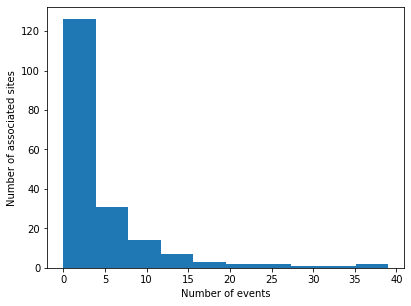

In [27]:
sites:0!select sum target by site_no from cleaned_peak
plt[`:hist][sites`target];
plt[`:xlabel]["Number of events"];
plt[`:ylabel]["Number of associated sites"];
plt[`:show][];

The splitting of this dataset is slightly more involved. In order to test generalization to new areas the data is split such that sites cannot appear in both the training and testing sets. In addition to this given the uneven distribution of events in each site the data is stratified such that the training and testing sets contain sites which have similar levels of flood activity.

In [28]:
// Set the number of events associated with each bin of the dataset
bins:0 5 15 25.0

// Split the target data into their associated bins
y_binned:bins bin`float$sites`target

// Using embedPy stratify site numbers and targets into an 80-20 train-test split of the data
tts:train_test_split[sites[`site_no];sites[`target];`test_size pykw 0.2; `random_state pykw 607;
    `shuffle pykw 1b;`stratify pykw y_binned]`;

// Update the cleaned_peak data such that a flag indicating training/testing set is denoted
cleaned_peak[`split]:`TRAIN
peak_split:update split:`TEST from cleaned_peak where site_no in`$tts[1]

// As in the Monthly model use the split_dict function to appropriately split the dataset
XtrainPi:select from peak_split where split=`TRAIN
ytrainP:exec target from peak_split where split=`TRAIN
XtestPi:select from  peak_split where split=`TEST
ytestP:exec target from peak_split where split=`TEST

XtrainP:split_dict[XtrainPi;`P]
XtestP:split_dict[XtestPi;`P]

## Model Building and Evaluation

Thoughout the course of this work a wide variety of models were tested including Neural networks, however for the sake of this notebook, only models and results from an eXtreme Gradient Boost (XGBoost) and random forest classifier are presented below. These models were chosen due to their ability to deal with complex, imbalanced datasets. A more indepth discussion of these models can also be found in the associated whitepaper.

In The following cell outlines a function used to fit both a Random-Forest classifier and XGBoost mode. This function returns a fitted model for each algorithm.

In [29]:
build_model:{[Xtrain;ytrain;dict]
 rf_hyp_nms:`n_estimators`random_state`class_weight;
 rf_hyp_vals:(dict`rf_n;0;(0 1)!(1;dict`rf_wgt));
 rf_clf:RandomForestClassifier[pykwargs rf_hyp_nms!rf_hyp_vals][`:fit][Xtrain; ytrain];

 xgb_hyp_nms:`n_estimators`learning_rate`random_state`scale_pos_weight`max_depth;
 xgb_hyp_vals:(dict`xgb_n;dict`xgb_lr;0;dict`xgb_wgt;dict`xgb_maxd);
 xgb_clf: XGBClassifier[pykwargs xgb_hyp_nms!xgb_hyp_vals][`:fit][np[`:array]Xtrain; ytrain];
 
 `random_forest`XGB!(rf_clf;xgb_clf)}

These models are used in the results section below in conjunction with the function `pr_curve` to test their performance on the training set. This function is used both to visulaize the results in the form of a PR curve but also to provide important metrics

**pr_curve[ xtest ; ytest ; dict ]**

* xtest = matrix of feature values
* ytest = list of targets 
* dict  = dictionary of fitted models produced by build_model above

The output information from this function is as follows

1. Overall accuracy of the model 
2. Mean-Class accuracy which is a 'fairer' accuracy metric
3. Classification report outlining overall and class based precision, recall and f1-score
4. The precision-recall curves for each model and the area under the curve associated with each 

## Results

The scores and graphics in the results below are separated based on the three datasets created and sub divided into the monthly and time to peak models.

Following display of the graphics and scores a summary of the results for each section is provided.

### Ungauged Prediction 

#### Monthly Model


Accuracy for random_forest: 0.939347


Meanclass accuracy for random_forest: 0.8531552


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9428694 0.9950011 0.9682341 13203  
1        | 0.7634409 0.2111001 0.3307453 1009   
avg/total| 0.8531552 0.6030506 0.6494897 14212  


/home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Accuracy for XGB: 0.9194343


Meanclass accuracy for XGB: 0.6852168


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9510024 0.9628872 0.9569079 13203  
1        | 0.4194313 0.3508424 0.3820831 1009   
avg/total| 0.6852168 0.6568648 0.6694955 14212  


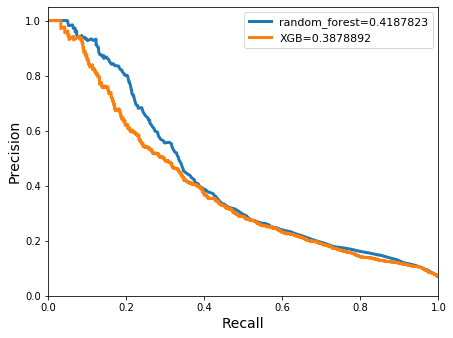

In [30]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(200;1;8;200;.2;15;7)

models:build_model[XtrainM`ungauged;ytrainM;dict]

pltU1:pr_curve[XtestM`ungauged;ytestM;models]

#### Time to Peak Model


Accuracy for random_forest: 0.7619926


Meanclass accuracy for random_forest: 0.7838651


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7552301 0.9678284 0.8484136 373    
1        | 0.8125    0.3076923 0.4463519 169    
avg/total| 0.7838651 0.6377604 0.6473828 542    


/home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Accuracy for XGB: 0.7712177


Meanclass accuracy for XGB: 0.7350241


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.8104738 0.8713137 0.8397933 373    
1        | 0.6595745 0.5502959 0.6       169    
avg/total| 0.7350241 0.7108048 0.7198966 542    


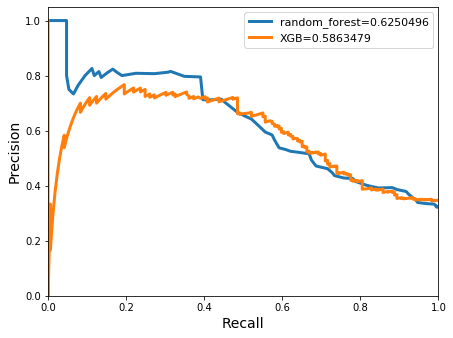

In [31]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;350;.01;1.5;3)

models:build_model[XtrainP`ungauged;ytrainP;dict]

pltU2 :pr_curve[XtestP`ungauged;ytestP;models]

### Gauged Prediction

#### Monthly Model


Accuracy for random_forest: 0.9433577


Meanclass accuracy for random_forest: 0.9112028


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9446277 0.9975006 0.9703444 13203  
1        | 0.8777778 0.234886  0.370602  1009   
avg/total| 0.9112028 0.6161933 0.6704732 14212  


/home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Accuracy for XGB: 0.9345623


Meanclass accuracy for XGB: 0.7541277


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9560758 0.974324  0.9651137 13203  
1        | 0.5521797 0.4142716 0.4733862 1009   
avg/total| 0.7541277 0.6942978 0.7192499 14212  


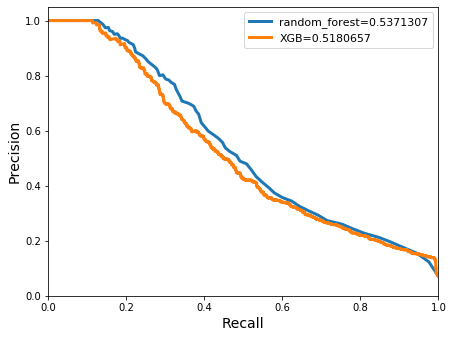

In [41]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;16;8;100;0.2;16;9)

models:build_model[XtrainM`gauged;ytrainM;dict]

pltG1:pr_curve[XtestM`gauged;ytestM;models]

#### Time to Peak Model


Accuracy for random_forest: 0.7361624


Meanclass accuracy for random_forest: 0.7518134


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7327935 0.9705094 0.8350634 373    
1        | 0.7708333 0.2189349 0.3410138 169    
avg/total| 0.7518134 0.5947221 0.5880386 542    


/home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Accuracy for XGB: 0.7730627


Meanclass accuracy for XGB: 0.7415102


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.8004808 0.8927614 0.8441065 373    
1        | 0.6825397 0.5088757 0.5830508 169    
avg/total| 0.7415102 0.7008186 0.7135787 542    


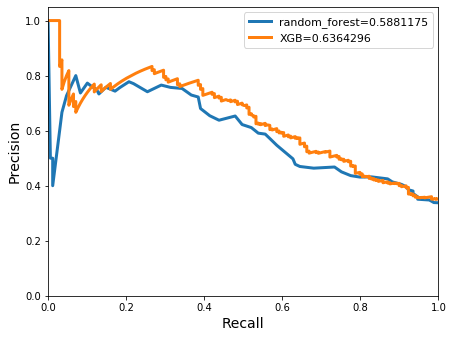

In [33]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;360;0.01;1.5;3)

models:build_model[XtrainP`gauged;ytrainP;dict]

pltG2 :pr_curve[XtestP`gauged;ytestP;models]

### Perfect Forecast

#### Monthly Model


Accuracy for random_forest: 0.9457501


Meanclass accuracy for random_forest: 0.9167146


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9470656 0.9973491 0.9715572 13203  
1        | 0.8863636 0.2705649 0.4145786 1009   
avg/total| 0.9167146 0.633957  0.6930679 14212  


/home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Accuracy for XGB: 0.9430059


Meanclass accuracy for XGB: 0.7838452


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9694674 0.9691737 0.9693205 13203  
1        | 0.5982231 0.6005946 0.5994065 1009   
avg/total| 0.7838452 0.7848842 0.7843635 14212  


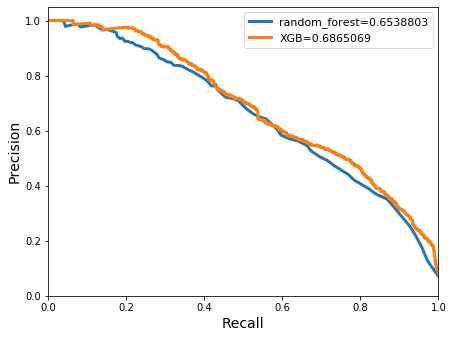

In [34]:
dict:`rf_n`rf_wgt`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;15;100;0.2;15;7)

models:build_model[XtrainM`forecast;ytrainM;dict]

pltP1:pr_curve[XtestM`forecast;ytestM;models]

#### Time to Peak Model


Accuracy for random_forest: 0.7490775


Meanclass accuracy for random_forest: 0.7584268


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7463617 0.9624665 0.8407494 373    
1        | 0.7704918 0.2781065 0.4086957 169    
avg/total| 0.7584268 0.6202865 0.6247225 542    


/home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Accuracy for XGB: 0.7435424


Meanclass accuracy for XGB: 0.7007658


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.8111702 0.8176944 0.8144192 373    
1        | 0.5903614 0.5798817 0.5850746 169    
avg/total| 0.7007658 0.698788  0.6997469 542    


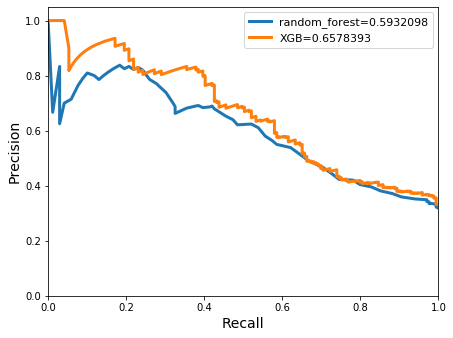

In [35]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;300;0.01;2.5;3)

models:build_model[XtrainP`forecast;ytrainP;dict]

pltP2 :pr_curve[XtestP`forecast;ytestP;models]

### Scoring Summary

**Ungauged Models**

The monthly model obtained highest accuracy scores using random forests, while the time to peak model performed best for XGBoost. In both cases, random forests achieved high precision scores and low recall results. Meanwhile, XGBoost gave a slightly more balanced precision/recall result.

**Gauged Models**

Accuracy for the monthly model improved when compared with the previous predictions, whereas a decrease was observed for the time to peak model.

**Perfect Forecast Models**

In the above case, the XGBoost classifier achieved the hightest accuracy score in both models. Once again, XGBoost also gave a more balanced precision/recall score for both models.


### Feature Significance

There is also a lot to be learned from determining which features contribute to predicting the target for a model. As such analysis could allow decision makers to prioritise the information used to make decisions.

To find the features which were deemed statistically significant to prediction of the target, the function `ml.fresh.significantfeatures` from the machine learning toolkit was used. The top 15 features in both the monthly and time to peak models were found using `ml.fresh.ksigfeat[x]`.

The cell below defines some functionality used for the evaluation of both models:

In [36]:
title:{"The top 15 significant features for ",x," predictions are:"}
nums :{string[1+til x],'x#enlist". "}
// define the projection to be used by .ml.fresh.significantfeatures
kfeat:.ml.fresh.ksigfeat 15

#### Monthly Model

In [37]:
title["monthly"]
X_Month:flip forecast[`M]!cleaned_monthly[forecast[`M]]
y_Month:cleaned_monthly`target
3 cut`$nums[15],'string .ml.fresh.significantfeatures[X_Month;y_Month;kfeat]

"The top 15 significant features for monthly predictions are:"


1. lagged_target_all     2. window_ppt_1          3. window_ppt_2        
4. window_ppt_3          5. window_ppt_4          6. window_ppt_5        
7. window_ppt_6          8. window_upstr_ppt_1_1  9. window_upstr_ppt_1_2
10. window_upstr_ppt_1_3 11. window_upstr_ppt_1_4 12. lagged_target_1    
13. lagged_target_12     14. window_upstr_ppt_1_5 15. window_ppt_7       


#### Time to Peak Model

In [38]:
title["time-peak"]
X_t2p:flip forecast[`P]!cleaned_peak[forecast[`P]]
y_t2p:cleaned_peak`target
3 cut`$nums[15],'string .ml.fresh.significantfeatures[X_t2p;y_t2p;kfeat]

"The top 15 significant features for time-peak predictions are:"


1. WsAreaSqKmRp100       2. WsAreaSqKm          3. wind_prev_height_48
4. prev_upstr_height_1_1 5. wind_prev_height_12 6. prev_height_1      
7. prev_height_5         8. WetIndexCat         9. prev_height_4      
10. prev_height_6        11. prev_height_7      12. prev_height_2     
13. prev_height_8        14. wind_prev_height_4 15. prev_height_3     


## Graphics 

#### Monthly Model

Using these results, it was also possible to build a map highlighting which areas are at risk of flooding each month. This could be used by governmental bodies to prioritize funding in the coming weeks.

In [39]:
preds:last pltP1`model
newtst:update preds:preds from XtestMi
newt:select from newtst where date within 2018.01 2018.12m,preds=1
dfnew:.ml.tab2df newt
graphs:.p.get`AcledExplorer
graphs[`df pykw dfnew][`:render][];

**Note**

For clarity this uses a python function contained in the file `../code/graphics.p` from this directory. The use of interactive widgets in a JupyterQ through embedPy is limited in scope.

#### Time to Peak Model

Given the information that has been extracted from above a comparison between the predicted time that a stream will reach it's peak height can be compared to the actual time of the peak height event. This is shown in the graphic below.

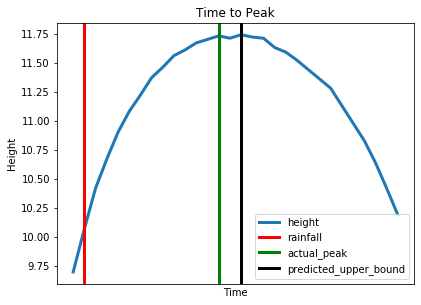

In [40]:
// Extract the predictions for the ungauged model
pred:last pltU2`model

// For a specific site extract the start, peak and end times of an event
pg:raze select site_no,start_time,end_time,peak_time from XtrainPi 
    where unk=`EDT,i in where pred=XtestPi`target,site_no=`02164110,
    target=1,delta_peak>2

// Definition of parameters used in plotting
rainfall   :`x_val`col`title!(pg[`start_time];`r;`rainfall)
actual_peak:`x_val`col`title!(pg[`peak_time];`g;`actual_peak)
pred_bound :`x_val`col`title!(03:30+pg[`start_time];`black;`predicted_upper_bound)

// Extract the relevant information for site around the time of a major rainfall event
graph:select from str where date within (`date$pg[`start_time];`date$pg[`end_time]), datetime
      within (neg[00:15]+pg[`start_time];[00:10]+pg[`end_time]),(value pg`site_no)=`$site_no

// Plot the the height as a function of time
times  :graph`datetime
heights:graph`height
plt_params:`label`linewidth!(`height;3)
plt[`:plot][times;heights;pykwargs plt_params];

// Function used to plot lines indicating relevant events
pltline:{
  dict:`color`label`linewidth!(x`col;x`title;3);
  plt[`:axvline][x`x_val;pykwargs dict];}

pltline each(rainfall;actual_peak;pred_bound);

plt[`:legend][`loc pykw `best];
plt[`:title]["Time to Peak"];
plt[`:ylabel]["Height"];
plt[`:xlabel]["Time"];
plt[`:xticks][()];
plt[`:show][];

## Conclusion

From the above results we could predict, with relatively high accuracy, whether an area was likely to flood or not in the next month. We could also produce a model to predict if a stream would reach its peak height within 3.5 hours.

For the monthly models, the future weather predictions played an important role in predicting whether an area would flood or not. Accuracy, recall and precision all increased as the weather predictions and gauged information columns were added to the dataset. This corresponded with the results from the significant feature tests, with lagged_target information and also the windowed rain values of the current month being the most important features to include.

The opposite was true for the time-peak values, as previous rain and stream gauge information along with the basin characteristics were seen to be the most significant features when predicting these values. Including additional information about the future predicted rainfall decreased the accuracy of the results, with the best results being obtained from the model with only past rainfall and basin and soil characteristics being fed into the model.

Both of these results are likely be physically expected. In the case of the monthly prediction, information regarding future forecast was pivotal in whether an area will flood in the next month. Whereas in the case of a time to peak value, it would be unlikely that information about rainfall in the next number of days would add to the predictive power of a model.

Knowing what features contribute to flood susceptibility and the length of time it takes for a river to reach its peak height, is an important piece of information to extract from the model. From this, organizations such as USGS can better prepare for flood events and understand how changing climates and placement of impervious surface can affect the likelihood of flooding.

The best results from the models above were obtained by continuously adjusting the hyper-parameters of the model. The unbalanced target data in the monthly model, meant that weighting the classes was an important feature to experiment with. This was particularly important when trying to obtain high precision and recall results. Between the two models, balance in the recall and precision was better for the XGBoost model.